In [1]:
import sys; sys.path.append("..")
import numpy  as np
import torch
import matplotlib.pyplot as plt
import matplotlib
from model import ELM1D
from wrapper import KS1DModelWrapper

torch.set_grad_enabled(False)
torch.manual_seed(10)

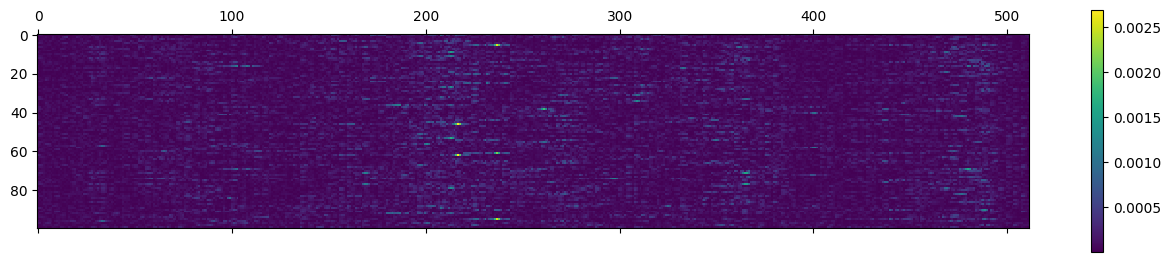

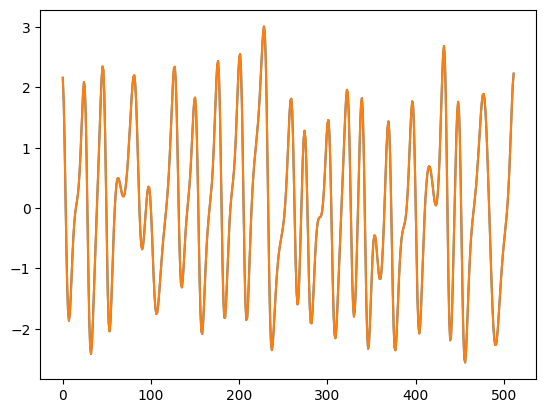

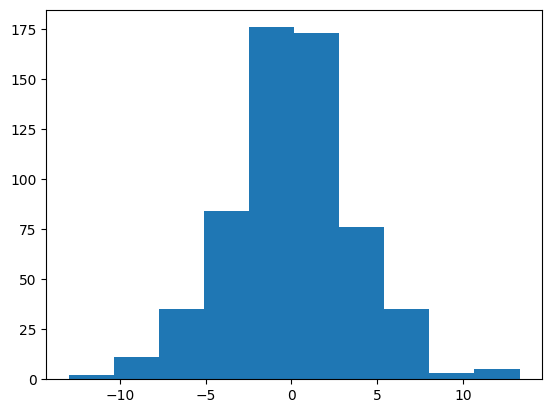

In [2]:
D_all = torch.tensor(np.load('ks1d.npy'))
D_train = D_all[:250,...]
D_test = D_all[-2000:,...]
N = D_all.shape[1]

I = torch.randint(D_test.shape[0]-1,(100,))
X_train = D_train[:-1,:]
Y_train = D_train[1:,:]
X_test = D_test[I,:]
Y_test = D_test[I+1,:]
errors = []

def cb(k,change,model):
    Y_pred = model(Y_test).detach()
    err = (Y_pred-Y_test).abs().mean()
    errors.append(err)

H = 150 
model = KS1DModelWrapper(ELM1D(7, 4, H))
model.train(X_train, Y_train, stopping_threshold=1e-3, noise=1e-4, callback=cb)

plt.colorbar(plt.matshow((model(X_test)-Y_test).abs()))
plt.show()

i = torch.argmax((model(X_test)-Y_test).abs().sum(dim=1))
plt.plot(Y_test[i,:].flatten())
plt.plot(model(X_test[i:i+1,:]).flatten())
plt.show()

plt.hist(model.model.lout.weight.data.view(-1))
plt.show()

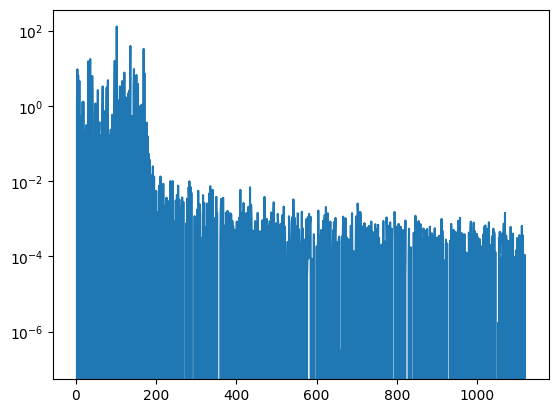

In [3]:
derrors = [errors[i+1]-errors[i] for i in range(len(errors)-1)]
plt.plot(derrors)
plt.yscale("log")
plt.show()

In [4]:
dt = .05
M = D_test.shape[0]

Y_pred = torch.empty(M, N, dtype=torch.float64)
Y_pred[0,:] = D_test[0,:].clone()
for i in range(M-1):
    Y_pred[i+1,:] = model(Y_pred[i,None,:]).detach()

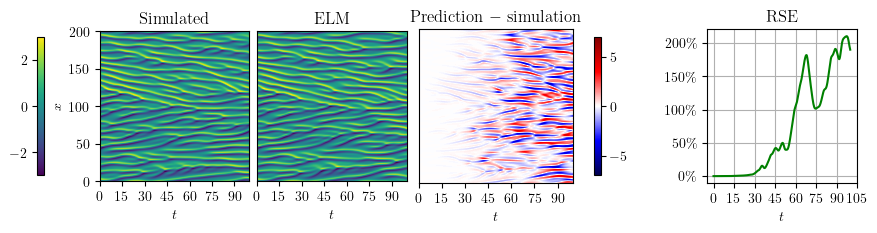

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

residual = Y_pred-D_test
rse = 100 * residual.pow(2) / (D_test - D_test.mean(dim=[1])[:,None]).pow(2).mean(dim=[1])[:,None]

fig = plt.figure(figsize=(10,2)) 
fig_l, fig_r = fig.subfigures(1,2,width_ratios=[3,0.7],wspace=-.05)
ax = fig_l.subplots(nrows=1, ncols=3, gridspec_kw={"wspace":.05})

aspect = 1/2
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[0].xaxis.set_major_locator(plt.MultipleLocator(15))
ax[1].xaxis.set_major_locator(plt.MultipleLocator(15))
ax[2].xaxis.set_major_locator(plt.MultipleLocator(15))
im0 = ax[0].imshow(D_test.numpy().T, vmax=3, vmin=-3, aspect=aspect, extent=[0,M*dt,0,200])
im1 = ax[1].imshow(Y_pred.numpy().T, vmax=3, vmin=-3, aspect=aspect, extent=[0,M*dt,0,200])
# im2 = ax[2].imshow(rse.numpy().T, norm=matplotlib.colors.LogNorm(vmin=1, vmax=1000), aspect=aspect, cmap="OrRd", extent=[0,M*dt,0,200])
im2 = ax[2].imshow(residual.numpy().T, vmin=-7, vmax=7, aspect=aspect, cmap="seismic", extent=[0,M*dt,0,200])
plt.colorbar(im0, ax=[ax[0],ax[1]], location="left", shrink=0.9, pad=0.13) # fraction=0.036, pad=0.04)
plt.colorbar(im2, ax=[ax[2]], location="right", shrink=0.9, pad=0.1) # , format="{x:.0f}\%")

ax[0].set_ylabel("$x$")
ax[0].set_xlabel("$t$")
ax[1].set_xlabel("$t$")
ax[2].set_xlabel("$t$")
ax[0].set_title("Simulated")
ax[1].set_title("ELM")
ax[2].set_title("Prediction $-$ simulation")

t = torch.linspace(0,M*dt,M).numpy()
ax = fig_r.subplots(1,1)
ax.plot(t, rse.mean(dim=1).numpy() / D_test.abs().mean(dim=1).numpy(), color="green")
from matplotlib import ticker
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,_: f"${x:.0f}\%$"))
ax.set_title("RSE")
ax.set_xlabel("$t$")
ax.xaxis.set_major_locator(plt.MultipleLocator(15))
ax.grid()

plt.savefig("plots/ks1d.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [6]:
dt = .05
M = D_test.shape[0]
Y_traj = D_test[:M,:]
H = 150

n_models = 50
residuals = torch.zeros(n_models, M, N)
for j in range(n_models):
    model = KS1DModelWrapper(ELM1D(8, 4, H))
    model.train(X_train, Y_train, stopping_threshold=1e-3, noise=1e-4)
    
    Y_pred = torch.empty(M, N, dtype=torch.float64)
    Y_pred[0,:] = Y_traj[0,:].clone()
    for i in range(M-1): Y_pred[i+1,:] = model(Y_pred[i,:])
    residuals[j,...] = Y_pred-Y_traj

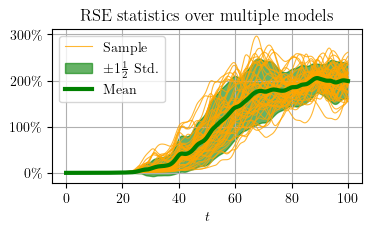

In [7]:
ms_residuals = 100 * residuals.pow(2).mean(dim=2) / (Y_traj - Y_traj.mean(dim=1)[:,None]).pow(2).mean(dim=1)
mean, std = ms_residuals.mean(dim=0), ms_residuals.std(dim=0)

fig, ax = plt.subplots(1, 1, figsize=(4,2))
t = torch.linspace(0, dt*M, M)
for k in range(n_models):
    label = "Sample" if k == 0 else None
    ax.plot(t, ms_residuals[k,...], color="orange", alpha=0.8, linewidth=0.8, label=label)
ax.fill_between(t, mean+1.5*std, mean-1.5*std, color="green", alpha=0.6, label="$\pm 1 \\frac 1 2 $ Std.")
ax.plot(t, mean, linestyle="-", color="green", linewidth=3, label="Mean")
ax.grid()
ax.legend()
from matplotlib import ticker
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,_: f"${x:.0f}\%$"))
ax.set_xlabel("$t$")
ax.set_title("RSE statistics over multiple models")

plt.savefig("plots/ks1d_multi_model_statistics.pdf", format="pdf", bbox_inches="tight")
plt.show()